In [5]:
# Borrowed from Metis class, generates integers.
def generate_numbers():
    """
    An infinite number generator ... stolen from Metis
    """
    x = 0
    while True:
        x += 1
        yield x # instead of return, I use yield, which makes this into a generator!

id_gen = generate_numbers()

In [7]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from glob import glob
from datetime import datetime, date, time, timedelta
from collections import defaultdict

In [8]:
# Set the number of rows to display when viewing dataframes / head / tail
pd.set_option("display.max_rows", 101)

In [9]:
# A function for viewing problematic rows. Show preceeding and following rows.
def sample(frame, index):
    """Returns three lines from a dataframe centered around the index parameter"""
    return frame.loc[index-1:index+1]

In [10]:
def am_pm(datetime_series):
    """Creates a Pandas Series object with the same index as the input index and values of
    AM or PM depeneding on the supplied timestamp."""
    s = pd.Series(index=datetime_series.index)
    for index, value in datetime_series.items():
        entry_time = datetime_series[index].time()
        if  entry_time > time(12,0,0) or entry_time == time(0,0,0):
            s[index] = 'PM'
        else:
            s[index] = 'AM'
    return s

In [11]:
def simplify_id(series):
    """Takes a series and changes the values to simple integers. This is to speed up comparisons"""
    s = pd.Series(index=series.index)
    id_set = set(series)
    d = {val : next(id_gen) for val in id_set}
    for index, value in series.iteritems():
        s[index] = d[value]
    return s

In [12]:
# Read data files
# list_of_data_files = glob('../data/*.txt')
list_of_data_files = glob('../data/turnstile_190330.txt')
list_of_data_files

# Read data files into pandas dataframes
list_of_dataframes = [pd.read_csv(file) for file in list_of_data_files]
df = pd.concat(list_of_dataframes)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


In [13]:
# Clean up strange spaces in column names
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [14]:
# Create a tuples of columns 'C/A', 'UNIT', 'SCP', 'STATION'
df['ID'] = pd.Series(zip(df['C/A'], df['UNIT'], df['SCP'], df['STATION']))

In [15]:
# Replace IDs created above with itengers because processing tuples is really slow
df['NEW_ID'] = simplify_id(df['ID'])

In [16]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ID,NEW_ID
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,"(A002, R051, 02-00-00, 59 ST)",3847.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,"(A002, R051, 02-00-00, 59 ST)",3847.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,"(A002, R051, 02-00-00, 59 ST)",3847.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,"(A002, R051, 02-00-00, 59 ST)",3847.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,"(A002, R051, 02-00-00, 59 ST)",3847.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204595 entries, 0 to 204594
Data columns (total 13 columns):
C/A         204595 non-null object
UNIT        204595 non-null object
SCP         204595 non-null object
STATION     204595 non-null object
LINENAME    204595 non-null object
DIVISION    204595 non-null object
DATE        204595 non-null object
TIME        204595 non-null object
DESC        204595 non-null object
ENTRIES     204595 non-null int64
EXITS       204595 non-null int64
ID          204595 non-null object
NEW_ID      204595 non-null float64
dtypes: float64(1), int64(2), object(10)
memory usage: 20.3+ MB


In [18]:
# Filter out df['DESC'] == 'RECOVR AUD'. These entries create large jumps in entry counts
df = df[df['DESC'] != 'RECOVR AUD']

In [19]:
# Add a weekday column
df['DATE_TIME'] = df['DATE'] + ' ' + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['WEEKDAY'] = df['DATE_TIME'].dt.day_name()

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [20]:
# Drop unneeded columns
df.drop(['LINENAME', 'DIVISION', 'DESC', 'C/A', 'UNIT', 'SCP', 'TIME', 'EXITS'], inplace=True, axis=1)

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
# Limit to one station for simplicity
# df = df[df['STATION'] == '59 ST']
df.head()

,STATION,DATE,ENTRIES,ID,NEW_ID,DATE_TIME,WEEKDAY
0,59 ST,03/23/2019,6989774,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 00:00:00,Saturday
1,59 ST,03/23/2019,6989795,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 04:00:00,Saturday
2,59 ST,03/23/2019,6989813,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 08:00:00,Saturday
3,59 ST,03/23/2019,6989924,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 12:00:00,Saturday
4,59 ST,03/23/2019,6990200,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 16:00:00,Saturday


In [22]:
# cache the number of rows for a future sanity check
rows_in_orig = df.shape[0]

In [23]:
# Create a disctiondary of dataframes for each turnstile id for entry count processing
dict_of_ids = {id : df[df['NEW_ID'] == id] for id in df['NEW_ID'].unique()}

In [25]:
# Sanity check to be sure things worked
dict_of_ids[3847.0].head()

,STATION,DATE,ENTRIES,ID,NEW_ID,DATE_TIME,WEEKDAY
0,59 ST,03/23/2019,6989774,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 00:00:00,Saturday
1,59 ST,03/23/2019,6989795,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 04:00:00,Saturday
2,59 ST,03/23/2019,6989813,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 08:00:00,Saturday
3,59 ST,03/23/2019,6989924,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 12:00:00,Saturday
4,59 ST,03/23/2019,6990200,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 16:00:00,Saturday


In [26]:
# Create Entry counts based on subtracting a an entry count from the entry count in the next row.
for key, frame in dict_of_ids.items():
    dict_of_ids[key]['ENTRY_COUNT'] = abs(frame['ENTRIES'] - frame['ENTRIES'].shift(1))
    dict_of_ids[key]['ENTRY_COUNT'].fillna(0, inplace=True)

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [27]:
# Recombine the dataframe from the dictionary of dataframes, now with entry counts
df = pd.concat(dict_of_ids.values())

In [28]:
# Check the number of rows to be sure we didn't gain or lose anything
assert(df.shape[0] == rows_in_orig)

In [29]:
df.shape

(203876, 8)

In [30]:
# Filter out counts larger than 300 because they are almost always turnstile resets.
df = df[df['ENTRY_COUNT'] < 3000]

In [31]:
# Create a DATE column from the DATE_TIME timestamp.
df['DATE'] = df['DATE_TIME'].dt.date

In [32]:
df.head()

,STATION,DATE,ENTRIES,ID,NEW_ID,DATE_TIME,WEEKDAY,ENTRY_COUNT
0,59 ST,2019-03-23,6989774,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 00:00:00,Saturday,0.0
1,59 ST,2019-03-23,6989795,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 04:00:00,Saturday,21.0
2,59 ST,2019-03-23,6989813,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 08:00:00,Saturday,18.0
3,59 ST,2019-03-23,6989924,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 12:00:00,Saturday,111.0
4,59 ST,2019-03-23,6990200,"(A002, R051, 02-00-00, 59 ST)",3847.0,2019-03-23 16:00:00,Saturday,276.0


In [44]:
# Sum up entry counts by date and weekday. This is a little redundant, but the WEEKDAY
# column is needed for later processing.
gp_date_weekday = df.groupby(['STATION', 'DATE', 'WEEKDAY'], as_index=False).sum()

In [47]:
gp_date_weekday.head()

,STATION,DATE,WEEKDAY,ENTRIES,NEW_ID,ENTRY_COUNT
0,1 AV,2019-03-23,Saturday,8476143515,147132.0,9810.0
1,1 AV,2019-03-24,Sunday,8476218409,147132.0,11413.0
2,1 AV,2019-03-25,Monday,8022381943,135052.0,18759.0
3,1 AV,2019-03-26,Tuesday,8476413906,147132.0,19013.0
4,1 AV,2019-03-27,Wednesday,7517718898,134690.0,20302.0


In [48]:
# Calculate the mean number of entries for each station.
daily_mean_by_station = gp_date_weekday.groupby('STATION', as_index=False).mean()

In [49]:
# Round off the mean values as they have a crazy number of decimal places.
daily_mean_by_station['ENTRY_COUNT'] = daily_mean_by_station['ENTRY_COUNT'].round(0)
# daily_mean_by_station.sort_values('ENTRY_COUNT', ascending=False, inplace=True)

In [62]:
# 
five_largest = daily_mean_by_station.nlargest(5, 'ENTRY_COUNT').sort_values('ENTRY_COUNT', ascending=False)
station = five_largest.STATION
entry_counts = five_largest.ENTRY_COUNT
five_largest

,STATION,ENTRIES,NEW_ID,ENTRY_COUNT
61,34 ST-PENN STA,2.342218e+10,1.576306e+06,143527.0
232,GRD CNTRL-42 ST,1.372495e+10,1.001050e+06,128234.0
59,34 ST-HERALD SQ,2.840397e+10,6.620903e+05,110187.0
46,23 ST,3.475568e+10,1.035918e+06,99526.0
14,14 ST-UNION SQ,4.894327e+09,4.634617e+05,90159.0


In [69]:
new_index = list(reversed(station.index))
new_index

[14, 46, 59, 232, 61]

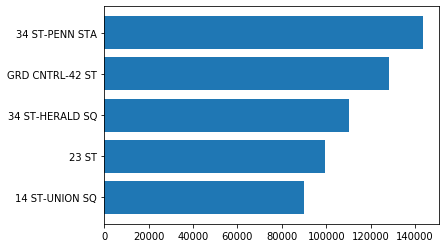

In [75]:
plt.barh(station[new_index], entry_counts[new_index]);

In [77]:
top_ten_stations = daily_mean_by_station.nlargest(10, 'ENTRY_COUNT').STATION
top_ten_stations

61      34 ST-PENN STA
232    GRD CNTRL-42 ST
59     34 ST-HERALD SQ
46               23 ST
14      14 ST-UNION SQ
68     42 ST-PORT AUTH
351     TIMES SQ-42 ST
225          FULTON ST
110              86 ST
9               125 ST
Name: STATION, dtype: object

In [74]:
top_ten_df = 
gp_station_weekday = gp_date_weekday.groupby(['STATION', 'WEEKDAY'], as_index=False).mean()
gp_station_weekday.head(60)

,STATION,WEEKDAY,ENTRIES,NEW_ID,ENTRY_COUNT
0,1 AV,Friday,10394440597,172016.0,21596.0
1,1 AV,Monday,8022381943,135052.0,18759.0
2,1 AV,Saturday,8476143515,147132.0,9810.0
3,1 AV,Sunday,8476218409,147132.0,11413.0
4,1 AV,Thursday,8476654460,147132.0,20793.0
5,1 AV,Tuesday,8476413906,147132.0,19013.0
6,1 AV,Wednesday,7517718898,134690.0,20302.0
7,103 ST,Friday,13488904680,237858.0,30861.0
8,103 ST,Monday,13488231067,237858.0,29552.0
9,103 ST,Saturday,13488016917,237858.0,17148.0


***

In [28]:
pickle.dump(df, open( "NYC_TS_DF.pickle", "wb" ) )

In [ ]:
len(df.STATION.unique())

In [ ]:
df['ENTRY_COUNTS'] = count_entries(df)

In [ ]:
df['PCT_RANK'] = (df['ENTRY_COUNTS'].rank(pct=True) * 100).round(0)

In [ ]:
df.head()

In [ ]:
df[df['PCT_RANK'] == 99].shape

In [ ]:
# Filter out ENTRY_COUNTS greater than 3000 because these are usually counter resets
df = df[df['ENTRY_COUNTS'] < 3000]

In [ ]:
df[df['ENTRY_COUNTS'] < 0]

In [ ]:
print(df['ENTRY_COUNTS'].min(), df['ENTRY_COUNTS'].max()) 

In [ ]:
df['AM/PM'] = am_pm(df['DATE_TIME'])

In [ ]:
df.head()

In [ ]:
gp = df.groupby(['STATION', 'WEEKDAY', 'AM/PM'], as_index=False).sum()

In [ ]:
gp.head(100)

In [ ]:
gp_sorted = gp.sort_values(['ENTRY_COUNTS'], ascending=False)

In [ ]:
gp_sorted.nlargest(20, 'ENTRY_COUNTS')

In [ ]:
plt.hist(df.ENTRY_COUNTS[df.ENTRY_COUNTS < 2000])

In [ ]:
df = df[df['ENTRY_COUNTS'] < 4000]

In [ ]:
df.loc[36217:36221]

In [ ]:
df.ENTRY_COUNTS.median()

In [ ]:
df.ENTRY_COUNTS.mean()

In [ ]:
df.head()

In [ ]:
# Create a dict dataframes that contain the turnstile data for each station
dict_of_station_frames = {station : df[df.STATION == station] for station in df['STATION'].unique()}
len(dict_of_station_frames.keys())

In [ ]:
dict_of_station_frames['59 ST'].head()

In [ ]:
for name in dict_of_station_frames.keys():
    print(name + ':\n')
    print(dict_of_station_frames[name].describe())

In [ ]:
station_counts = defaultdict(int)
for name in dict_of_station_frames.keys():
    frame = dict_of_station_frames[name].copy()
    frame['ENTRY_COUNT'] = frame['ENTRIES'] - frame['ENTRIES'].shift(1)
    frame['ENTRY_COUNT'].fillna(0, inplace=True)
    dict_of_station_frames[name] = frame
    print(dict_of_station_frames[name].head(5))
    station_counts[name] = dict_of_station_frames[name]['ENTRY_COUNT'].sum()

In [ ]:
for key, value in station_counts.items():
    print(key, ':', value)

In [ ]:
for name in dict_of_station_frames.keys():
    

In [ ]:
df.head()

In [ ]:
# Filter data to daylight hours
times = ['12:00:00', '16:00:00', '20:00:00']
df = df[df['TIME'].isin(times)]

In [ ]:
gd = df.groupby(['STATION', 'WEEKDAY', 'TIME'], as_index=False).count()

In [ ]:
gd.head()